**Team Name: Moose**

**Members:<br> Scott Pramuk, smpramuk@calpoly.edu <br>
Hailey Ernest, hernest@calpoly.edu <br>
Iliya Dehsarvi idehsarv@calpoly.edu <br>
Arian Housh ahoushma@calpoly.edu**


**Notebook Author: Scott Pramuk, smpramuk@calpoly.edu**

***Question 1: Can we predict the sector to which a company belongs based on financial information (i.e. stock price) we have about the company?***

In [126]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, precision_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt

In [127]:
df = pd.read_csv("2014_Financial_Data.csv")
features_rough = ["Unnamed: 0","Net Income", "Revenue","Gross Profit","Revenue Growth","Asset Growth","Net Income Growth","Debt Growth","Receivables growth","Inventory Growth","2015 PRICE VAR [%]", "Sector"]
df_small = df[features_rough].rename(
    columns={"Unnamed: 0": "Name", "2015 PRICE VAR [%]": "2015  % Price Change"}
)
features = list(df_small.columns)
df_small = df_small.dropna()
yearly_accuracies = dict()
yearly_k_values = dict()
df

,Unnamed: 0,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2015 PRICE VAR [%],Class
0,PG,7.440100e+10,-0.0713,3.903000e+10,3.537100e+10,0.000000e+00,2.146100e+10,2.146100e+10,1.391000e+10,7.090000e+08,...,-0.0187,-0.0217,0.0359,0.0316,0.1228,0.0000,-0.1746,Consumer Defensive,-9.323276,0
1,VIPS,3.734148e+09,1.1737,2.805625e+09,9.285226e+08,1.083303e+08,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,...,NaN,NaN,NaN,NaN,NaN,1.6484,1.7313,Consumer Defensive,-25.512193,0
2,KR,9.837500e+10,0.0182,7.813800e+10,2.023700e+10,0.000000e+00,1.519600e+10,1.751200e+10,2.725000e+09,4.430000e+08,...,0.0618,0.0981,0.1886,0.3268,0.2738,0.0000,0.0234,Consumer Defensive,33.118297,1
3,RAD,2.552641e+10,0.0053,1.820268e+10,7.323734e+09,0.000000e+00,6.561162e+09,6.586482e+09,7.372520e+08,4.245910e+08,...,0.0211,-0.0510,-0.0189,0.1963,-0.0458,0.0000,-0.0060,Consumer Defensive,2.752291,1
4,GIS,1.790960e+10,0.0076,1.153980e+10,6.369800e+09,0.000000e+00,3.474300e+09,3.412400e+09,2.957400e+09,3.024000e+08,...,0.0257,0.0090,0.0215,0.0274,0.1025,0.0000,-0.0220,Consumer Defensive,12.897715,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3803,TSRI,4.952987e+07,0.1028,4.125164e+07,8.278229e+06,0.000000e+00,8.253061e+06,8.253061e+06,2.516800e+04,0.000000e+00,...,-0.0384,0.0000,-0.0041,-0.0049,0.0000,0.0000,0.0213,Technology,29.362884,1
3804,TZOO,1.532400e+08,-0.1019,1.917400e+07,1.340660e+08,1.132600e+07,1.125130e+08,1.162560e+08,1.781000e+07,0.000000e+00,...,0.1529,0.0000,-0.1872,0.1823,0.0000,0.2830,-0.0637,Technology,-31.167763,0
3805,USATP,4.200000e+07,NaN,2.700000e+07,1.500000e+07,NaN,1.400000e+07,1.500000e+07,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Technology,-23.558900,0
3806,WSTG,3.407580e+08,0.1344,3.159480e+08,2.481000e+07,0.000000e+00,1.651300e+07,1.651300e+07,8.297000e+06,-4.720000e+05,...,-0.0333,0.1338,0.0023,0.0890,0.0000,0.0000,0.0650,Technology,7.779579,1


**Note:** Chance of guessing sector by random probabability is: 0.09

In [128]:
print(1/df_small["Sector"].unique().shape[0])

0.09090909090909091


# Apparatus for Finding Best Subset of Features to Use:

In [129]:
from itertools import combinations

X = df_small[features]
y  = df_small["Sector"]

knn_classifier = KNeighborsClassifier(n_neighbors=6)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_accuracy = 0.0
best_subset = None

c = df_small.columns[1:(df_small.columns.shape[0]-1)]
# Loop over all possible subsets of columns
for r in range(1, len(c) + 1):
    for subset in combinations(c, r):
        X_temp_train = X_train[list(subset)]
        X_temp_test = X_test[list(subset)]
        # Fit the KNN classifier
        knn_classifier.fit(X=X_temp_train, y=y_train)

        # Make predictions
        y_pred = knn_classifier.predict(X_temp_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Update best accuracy and subset if needed
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_subset = subset
best_features = list(best_subset)
print(f"Best subset of columns: {best_subset}")
print(f"Best accuracy: {best_accuracy}")

Best subset of columns: ('Net Income', 'Revenue', 'Gross Profit')
Best accuracy: 0.36623748211731044


In [130]:
X = df_small[best_features]
y  = df_small["Sector"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn_classifier = KNeighborsClassifier(n_neighbors=10)


In [131]:
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)
SVMaccuracy = accuracy_score(y_test, y_pred)
# confusionMatrix = confusion_matrix(y_test)
print("SVM Test accuracy:",SVMaccuracy)

SVM Test accuracy: 0.18311874105865522


In [132]:
LR_classifier = LogisticRegression(max_iter=1000)
LR_classifier.fit(X_train, y_train)
y_pred = LR_classifier.predict(X_test)
LRaccuracy = accuracy_score(y_test, y_pred)
# confusionMatrix = confusion_matrix(y_test)
print("Logistic Regression Test accuracy:",LRaccuracy)

Logistic Regression Test accuracy: 0.19027181688125894


In [133]:
knn_classifier.fit(X_train, y_train)


y_predKNN = knn_classifier.predict(X_test)


KNNaccuracy = accuracy_score(y_test, y_predKNN)
print("KNN Classifier Test accuracy:",KNNaccuracy)

KNN Classifier Test accuracy: 0.38197424892703863


In [134]:
print("SVM Test accuracy:",SVMaccuracy)
print("Logistic Regression Test accuracy:",LRaccuracy)
print("KNN Classifier Test accuracy:",KNNaccuracy)

SVM Test accuracy: 0.18311874105865522
Logistic Regression Test accuracy: 0.19027181688125894
KNN Classifier Test accuracy: 0.38197424892703863


# NOTE
**KNN classifier significantly outperforms both LR and SVM, so I will use this model going forward.**

**Generating Confusion Matrix**

In [135]:

confusionMatrix = confusion_matrix(y_test,y_predKNN)


**Using SNS to help visualize errors via confusion matrix**

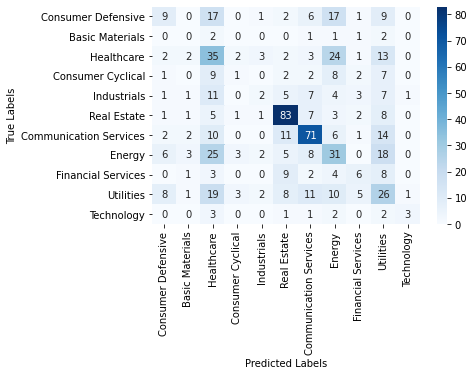

In [136]:
# Specify class labels
class_labels = list(df_small["Sector"].unique())

# Create a confusion matrix heatmap with labels
sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**Comments:** We can see from above that the model has the most difficulty distinguishing Energy companies from Healthcare companies based on the 2014 data. Some other sources of mistakes are between Utilities and Healthcare as well as Utilities and both Energy, Communication Services.

**Now to tune the K parameter for this model:**

In [137]:
knnHyperTune =  KNeighborsClassifier(n_neighbors = 5)
grid_search = GridSearchCV(KNeighborsClassifier(),param_grid = {"n_neighbors":range(2,50)},scoring="accuracy",cv=10)
grid_search.fit(df_small[best_features],df_small["Sector"])
n = grid_search.best_params_["n_neighbors"]
knnTuned = KNeighborsClassifier(n_neighbors = n)
yearly_k_values["2014"] = n
n

32

In [138]:


scoresAcc = cross_val_score(knnTuned,df_small[best_features],df_small["Sector"],scoring="accuracy",cv=10)
yearly_accuracies["2014"] = scoresAcc.mean()
print("Average accuracy from best KNN model:", scoresAcc.mean())


Average accuracy from best KNN model: 0.36769954973393365


In [139]:
knnTuned = KNeighborsClassifier(n_neighbors = n)
knnTuned.fit(X_train,y_train)
bestKNNPreds = knnTuned.predict(X_test)
confusionMatrix = confusion_matrix(y_test,bestKNNPreds)

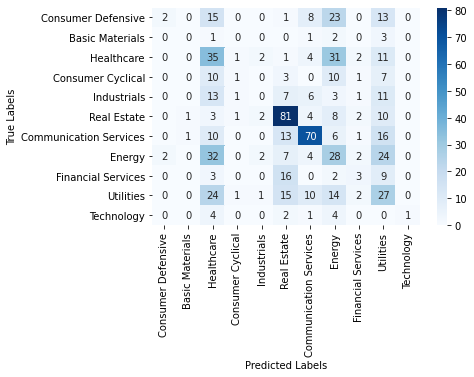

In [140]:
# Specify class labels
class_labels = list(df_small["Sector"].unique())

# Create a confusion matrix heatmap with labels
sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Q: Will other years yield different results?

In [141]:
allFeatures = best_features + ["Sector"]
allFeatures
df2015 = pd.read_csv("2015_Financial_Data.csv")
df2015 = df2015[allFeatures]
df2015 = df2015.dropna()

df2016 = pd.read_csv("2016_Financial_Data.csv")
df2016 = df2016[allFeatures]
df2016 = df2016.dropna()

df2017 = pd.read_csv("2017_Financial_Data.csv")
df2017 = df2017[allFeatures]
df2017 = df2017.dropna()

df2018 = pd.read_csv("2018_Financial_Data.csv")
df2018 = df2018[allFeatures]
df2018 = df2018.dropna()

# 2015 Data

In [142]:
X_2015 = df2015[best_features]
y_2015  = df2015["Sector"]

X_train2015, X_test2015, y_train2015, y_test2015 = train_test_split(X_2015, y_2015, test_size=0.2, random_state=42)



In [143]:
knnHyperTune =  KNeighborsClassifier(n_neighbors = 5)
grid_search = GridSearchCV(KNeighborsClassifier(),param_grid = {"n_neighbors":range(2,50)},scoring="accuracy",cv=10)
grid_search.fit(df2015[best_features],df2015["Sector"])
n = grid_search.best_params_["n_neighbors"]
knnTuned = KNeighborsClassifier(n_neighbors = n)
yearly_k_values["2015"] = n
n

49

In [144]:
scoresAcc = cross_val_score(knnTuned,df2015[best_features],df2015["Sector"],scoring="accuracy",cv=10)

yearly_accuracies["2015"] = scoresAcc.mean()
print("Average accuracy from best KNN model:", scoresAcc.mean())


Average accuracy from best KNN model: 0.38056265984654736


In [145]:
knnTuned = KNeighborsClassifier(n_neighbors = n)
knnTuned.fit(X_train2015,y_train2015)
bestKNNPreds = knnTuned.predict(X_test2015)
confusionMatrix2015 = confusion_matrix(y_test2015,bestKNNPreds)

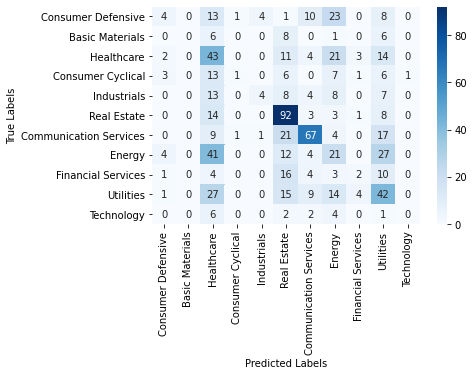

In [146]:
# Specify class labels
class_labels = list(df_small["Sector"].unique())

# Create a confusion matrix heatmap with labels
sns.heatmap(confusionMatrix2015, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [147]:
X_2016 = df2016[best_features]
y_2016  = df2016["Sector"]

X_train2016, X_test2016, y_train2016, y_test2016 = train_test_split(X_2016, y_2016, test_size=0.2, random_state=42)

In [148]:
knnHyperTune =  KNeighborsClassifier(n_neighbors = 5)
grid_search = GridSearchCV(KNeighborsClassifier(),param_grid = {"n_neighbors":range(2,50)},scoring="accuracy",cv=10)
grid_search.fit(df2016[best_features],df2016["Sector"])
n = grid_search.best_params_["n_neighbors"]
knnTuned = KNeighborsClassifier(n_neighbors = n)
yearly_k_values["2016"] = n
n

30

In [149]:
scoresAcc = cross_val_score(knnTuned,df2016[best_features],df2016["Sector"],scoring="accuracy",cv=10)

yearly_accuracies["2016"] = scoresAcc.mean()
print("Average accuracy from best KNN model:", scoresAcc.mean())

Average accuracy from best KNN model: 0.37898550724637675


In [150]:
knnTuned = KNeighborsClassifier(n_neighbors = n)
knnTuned.fit(X_train2016,y_train2016)
bestKNNPreds = knnTuned.predict(X_test2016)
confusionMatrix2016 = confusion_matrix(y_test2016,bestKNNPreds)

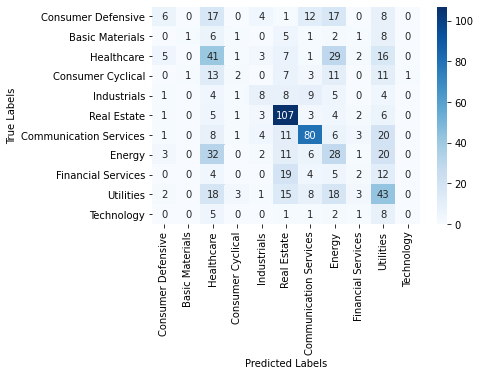

In [151]:
# Specify class labels
class_labels = list(df_small["Sector"].unique())

# Create a confusion matrix heatmap with labels
sns.heatmap(confusionMatrix2016, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [152]:
X_2017 = df2017[best_features]
y_2017  = df2017["Sector"]

X_train2017, X_test2017, y_train2017, y_test2017 = train_test_split(X_2017, y_2017, test_size=0.2, random_state=42)

In [153]:
knnHyperTune =  KNeighborsClassifier(n_neighbors = 5)
grid_search = GridSearchCV(KNeighborsClassifier(),param_grid = {"n_neighbors":range(2,50)},scoring="accuracy",cv=10)
grid_search.fit(df2017[best_features],df2017["Sector"])
n = grid_search.best_params_["n_neighbors"]
knnTuned = KNeighborsClassifier(n_neighbors = n)
yearly_k_values["2017"] = n
n

37

In [154]:
scoresAcc = cross_val_score(knnTuned,df2017[best_features],df2017["Sector"],scoring="accuracy",cv=10)

yearly_accuracies["2017"] = scoresAcc.mean()
print("Average accuracy from best KNN model:", scoresAcc.mean())

Average accuracy from best KNN model: 0.3780882706997308


In [155]:
knnTuned = KNeighborsClassifier(n_neighbors = n)
knnTuned.fit(X_train2017,y_train2017)
bestKNNPreds = knnTuned.predict(X_test2017)
confusionMatrix2017 = confusion_matrix(y_test2017,bestKNNPreds)

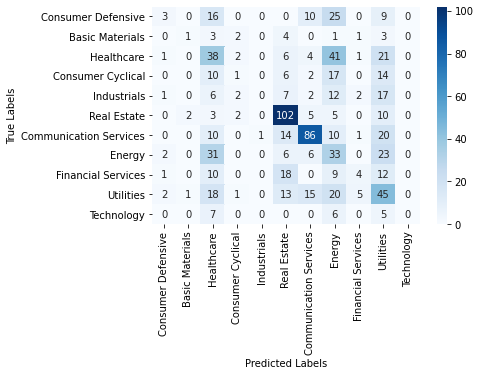

In [156]:
# Specify class labels
class_labels = list(df_small["Sector"].unique())

# Create a confusion matrix heatmap with labels
sns.heatmap(confusionMatrix2017, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [157]:
X_2018 = df2018[best_features]
y_2018  = df2018["Sector"]

X_train2018, X_test2018, y_train2018, y_test2018 = train_test_split(X_2018, y_2018, test_size=0.2, random_state=42)

In [158]:
knnHyperTune =  KNeighborsClassifier(n_neighbors = 5)
grid_search = GridSearchCV(KNeighborsClassifier(),param_grid = {"n_neighbors":range(2,50)},scoring="accuracy",cv=10)
grid_search.fit(df2018[best_features],df2018["Sector"])
n = grid_search.best_params_["n_neighbors"]
knnTuned = KNeighborsClassifier(n_neighbors = n)
yearly_k_values["2018"] = n
n

25

In [159]:
scoresAcc = cross_val_score(knnTuned,df2018[best_features],df2018["Sector"],scoring="accuracy",cv=10)

yearly_accuracies["2018"] = scoresAcc.mean()
print("Average accuracy from best KNN model:", scoresAcc.mean())

Average accuracy from best KNN model: 0.3733714058415729


In [160]:
knnTuned = KNeighborsClassifier(n_neighbors = n)
knnTuned.fit(X_train2018,y_train2018)
bestKNNPreds = knnTuned.predict(X_test2018)
confusionMatrix2018 = confusion_matrix(y_test2018,bestKNNPreds)

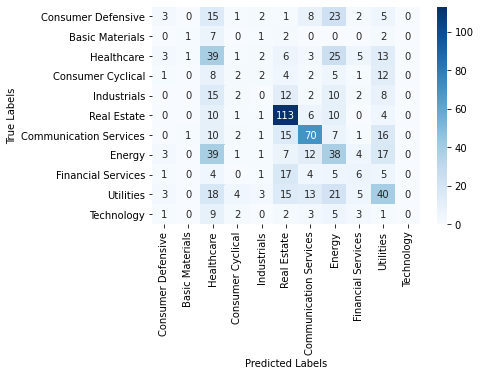

In [161]:
# Specify class labels
class_labels = list(df_small["Sector"].unique())

# Create a confusion matrix heatmap with labels
sns.heatmap(confusionMatrix2018, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [162]:
print("K-values for each year:\n", yearly_k_values,"\n")
print("Average CV accuracy for each optimal model:\n",yearly_accuracies)

K-values for each year:
 {'2014': 32, '2015': 49, '2016': 30, '2017': 37, '2018': 25} 

Average CV accuracy for each optimal model:
 {'2014': 0.36769954973393365, '2015': 0.38056265984654736, '2016': 0.37898550724637675, '2017': 0.3780882706997308, '2018': 0.3733714058415729}


In [ ]:
resultsDF = pd.DataFrame(list(yearly_accuracies.items()),columns=["Year","Average CV accuracy"])
resultsDF["K"] = yearly_k_values.values()
ax = resultsDF.plot.scatter(x="Year",y="Average CV accuracy",title="Average CV Accuracy by Year")
ax = resultsDF.plot.scatter(x="Year",y="Average CV accuracy",c="K",s=40,cmap="viridis",ax=ax)

plt.show()

In [170]:
resultsDF

,Year,Average CV accuracy,K
0,2014,0.367700,32
1,2015,0.380563,49
2,2016,0.378986,30
3,2017,0.378088,37
4,2018,0.373371,25


**Remarks:** Clearly it is hard for every model to correctly classify the sector of companies given limited financial information as seen by the average of ~37.5% accuracy among all models. Interestingly, every model had the most difficulty distiguishing between Energy and Healthcare companies. It is possible that the Energy and Healthcare sectors both had similar trends during these years.